## 1. Análisis Exploratorio
Descripción: Cargamos el CSV, definimos índice de fecha, inspeccionamos las columnas y visualizamos la serie de tiempo.

Columnas disponibles: ['Temperature']


,Temperature
Month,
1920-01-01,40.6
1920-02-01,40.8
1920-03-01,44.4
1920-04-01,46.7
1920-05-01,54.1


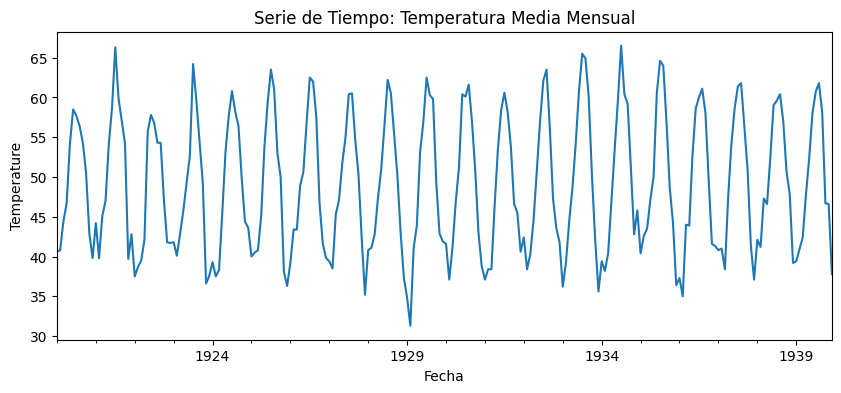

In [ ]:
# 1. Análisis Exploratorio
import pandas as pd
import matplotlib.pyplot as plt

# Carga y formateo
df = pd.read_csv('data/monthly-mean-temp.csv', parse_dates=['Month'])
df.set_index('Month', inplace=True)

# Inspecciona columnas y primeras filas
print("Columnas disponibles:", df.columns.tolist())
display(df.head())

# Asigna la serie de temperatura
temp_col = df.columns[0]
series = df[temp_col]

# Visualización
plt.figure(figsize=(10,4))
series.plot(title='Serie de Tiempo: Temperatura Media Mensual')
plt.xlabel('Fecha')
plt.ylabel(temp_col)
plt.show()


## 2. Promedios Móviles
Descripción: Calculamos MA(3) y MA(12) sobre la serie de temperatura y los comparamos con la serie original.

<Figure size 1000x400 with 0 Axes>

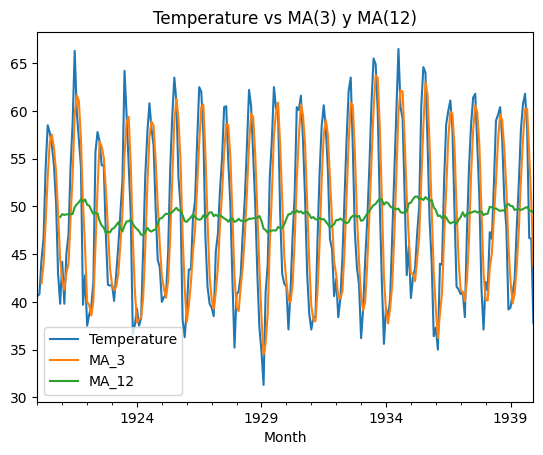

In [2]:
# 2. Promedios Móviles
df['MA_3']  = series.rolling(window=3).mean()
df['MA_12'] = series.rolling(window=12).mean()

plt.figure(figsize=(10,4))
df[[temp_col,'MA_3','MA_12']].plot()
plt.title(f'{temp_col} vs MA(3) y MA(12)')
plt.show()


## 3. Alisamiento Exponencial
Descripción: Aplicamos Simple Exponential Smoothing (SES) y Holt para capturar nivel y tendencia.

c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Figure size 1000x400 with 0 Axes>

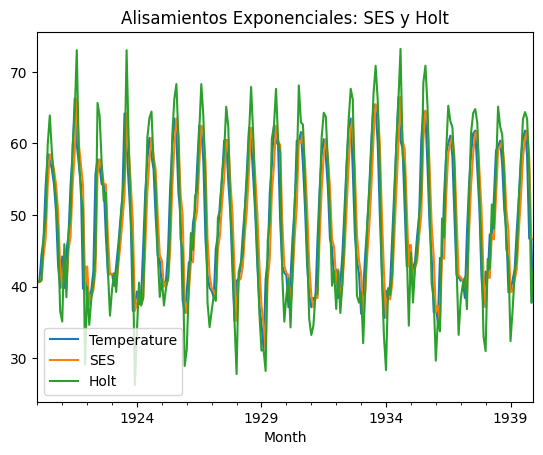

In [3]:
# 3. Alisamiento Exponencial
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

# SES
ses_model = SimpleExpSmoothing(series).fit()
df['SES'] = ses_model.fittedvalues

# Holt
holt_model = Holt(series).fit()
df['Holt'] = holt_model.fittedvalues

plt.figure(figsize=(10,4))
df[[temp_col,'SES','Holt']].plot()
plt.title('Alisamientos Exponenciales: SES y Holt')
plt.show()


## 4. Holt–Winters
Descripción: Ajustamos un modelo aditivo de Holt–Winters con estacionalidad anual (periodo = 12 meses).

c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Figure size 1000x400 with 0 Axes>

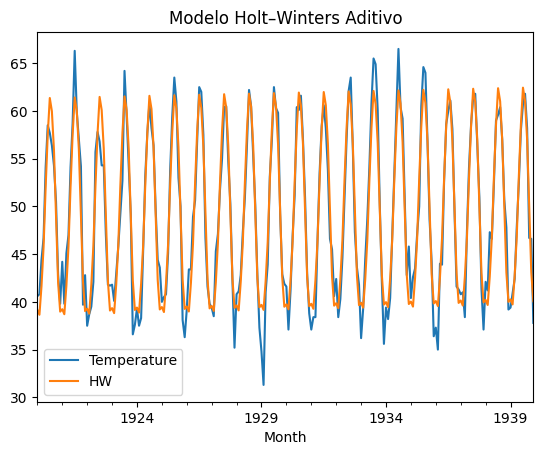

In [4]:
# 4. Holt–Winters
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_model = ExponentialSmoothing(
    series,
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()
df['HW'] = hw_model.fittedvalues

plt.figure(figsize=(10,4))
df[[temp_col,'HW']].plot()
plt.title('Modelo Holt–Winters Aditivo')
plt.show()


## 5. SARIMA
Descripción: Ajustamos un SARIMA(1,1,1)(1,1,1,12) y mostramos el ajuste.

c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\DELL I7\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Figure size 1000x400 with 0 Axes>

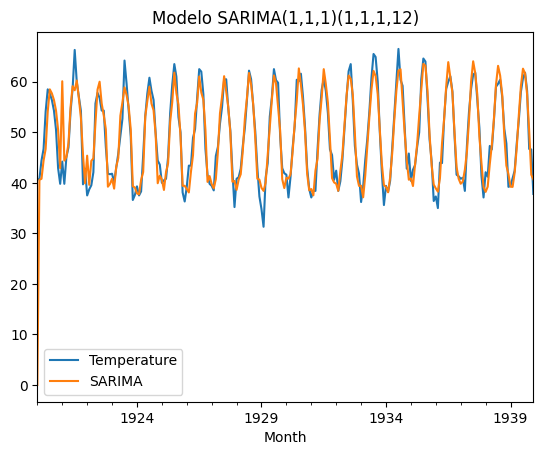

In [5]:
# 5. SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    series,
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
).fit(disp=False)
df['SARIMA'] = sarima_model.fittedvalues

plt.figure(figsize=(10,4))
df[[temp_col,'SARIMA']].plot()
plt.title('Modelo SARIMA(1,1,1)(1,1,1,12)')
plt.show()


## 6. Prophet
Descripción: Instalamos e importamos Prophet (o fbprophet), ajustamos y reconstruimos el ajuste.

22:49:19 - cmdstanpy - INFO - Chain [1] start processing
22:49:19 - cmdstanpy - INFO - Chain [1] done processing


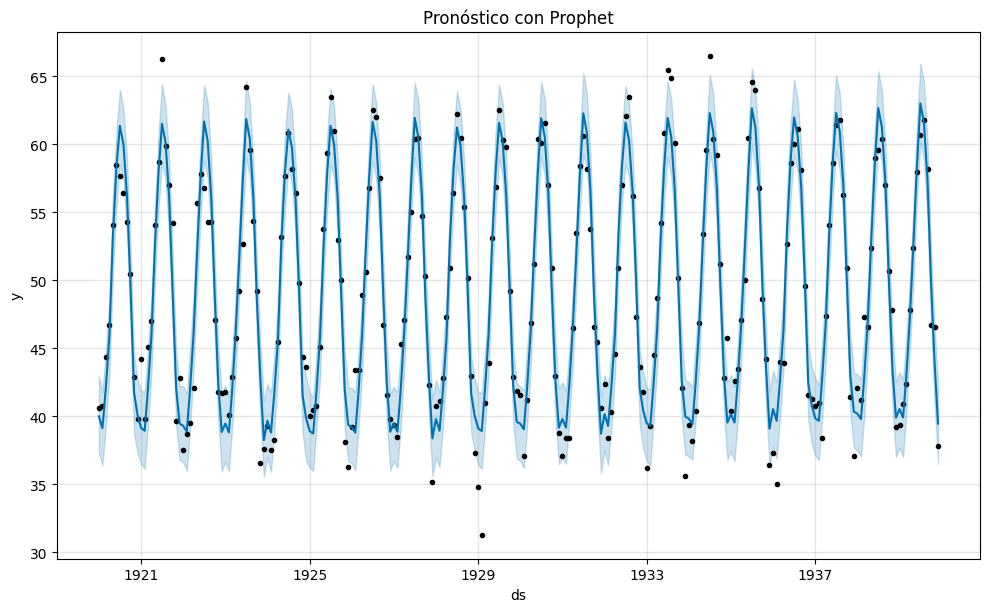

In [ ]:
# 6. Prophet
prophet_df = series.reset_index().rename(columns={temp_col:'y','Month':'ds'})

# Ajusta y predice
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False)
prophet_model.fit(prophet_df)

future  = prophet_model.make_future_dataframe(periods=0, freq='M')
forecast = prophet_model.predict(future)

# Grafica
df['Prophet'] = forecast.set_index('ds')['yhat']
fig = prophet_model.plot(forecast)
plt.title('Pronóstico con Prophet')
plt.show()


## 7. Comparación y Evaluación
Descripción: Calculamos RMSE y MAE para cada modelo y los comparamos.

In [8]:
# 7. Comparación y Evaluación
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

modelos = ['SES','Holt','HW','SARIMA','Prophet']
resultados = []

for m in modelos:
    mse  = mean_squared_error(series, df[m])
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(series, df[m])
    resultados.append({'Model':m,'RMSE':rmse,'MAE':mae})

metrics_df = pd.DataFrame(resultados).set_index('Model')
print("Métricas de Desempeño:")
display(metrics_df)


Métricas de Desempeño:


,RMSE,MAE
Model,,
SES,5.222436,4.297500
Holt,5.059002,4.012258
HW,2.230472,1.740147
SARIMA,3.779774,2.207331
Prophet,2.186984,1.700825
